In [1]:
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict
import os
from dotenv import load_dotenv
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage
import json
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableConfig
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, START
load_dotenv()

BASE_URL = "http://127.0.0.1:1234/v1"

## Define state

In [2]:
class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str


## Define tools

In [3]:
tools = [TavilySearch(max_results=1)]

## Define agents

### Planner Agents

In [4]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser
from langchain.chat_models import init_chat_model

class Plan(BaseModel):
    """Plan to follow in future"""

    steps: list[str] = Field(
        description="Different steps to follow, should be in sorted order"
    )

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan.
This plan should involve individual tasks, that if executed correctly will yield
the correct answer. Do not add any superfluous steps.
The result of the final step should be the final answer. Make sure that each step
has all the information needed - do not skip steps."""
        ),
        ("placeholder", "{messages}"),
    ]
)

planner = planner_prompt | init_chat_model(
    model="llama-3.2-3b-instruct",
    model_provider="openai",            # provider “openai” để dùng endpoint tương thích
    base_url=BASE_URL,  # URL server LM Studio
    api_key="lm-studio",                # có thể bất kỳ chuỗi nào
    temperature=0.7
).with_structured_output(Plan)

plan = planner.invoke({"input": "What is the weather in Vietnam?"})
print(plan)

steps=['Do you have a specific objective?', 'If yes, please provide it.', 'Once you have provided your objective, I will create a step-by-step plan for achieving it.']


### Executor agents

In [5]:
model = ChatOpenAI(
    base_url=BASE_URL,
    api_key="not-needed",  # LM Studio không yêu cầu API key
    temperature=0,
)
prompt = "You are a helpful assistant."
agent_executor = create_react_agent(model, tools, prompt=prompt)

In [6]:
agent_executor.invoke(
    {"messages": [("user", "How is the weather in Vietnam?")]})

{'messages': [HumanMessage(content='How is the weather in Vietnam?', additional_kwargs={}, response_metadata={}, id='e5784b1f-ce5e-45ed-8380-c1413991e1fa'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '657704391', 'function': {'arguments': '{"query":"Vietnam weather"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 1473, 'total_tokens': 1505, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'llama-3.2-3b-instruct', 'system_fingerprint': 'llama-3.2-3b-instruct', 'id': 'chatcmpl-96gw2knev99foaqobbzkc8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--de56013b-99c7-4a0f-84a7-8ebc13527887-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'Vietnam weather'}, 'id': '657704391', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1473, 'output_tokens': 32, 'total_tokens': 1505, 'input_token_details': {}, 'output_token_det

### Replanner Agents

In [8]:
from typing import Union

class Response(BaseModel):
    """Response to user."""

    response: str

"""
Trường action có thể là:
    - Response: trả lời luôn cho user (kết thúc).
Plan: lên/kế hoạch mới gồm các bước cần làm tiếp (nếu chưa đủ dữ kiện để trả lời hoặc task chưa xong).
Union dùng để cho phép output linh hoạt: hoặc trả lời user, hoặc lên kế hoạch mới.
"""
class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
                    "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan.
This plan should involve individual tasks, that if executed correctly will yield
the correct answer. Do not add any superfluous steps.
The result of the final step should be the final answer. Make sure that each step
has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to
the user, then respond with that. Otherwise, fill out the plan. Only add steps
to the plan that still NEED to be done. Do not return previously done steps
as part of the plan."""
)



replanner = replanner_prompt | init_chat_model(
    model="llama-3.2-3b-instruct",
    model_provider="openai",            # provider “openai” để dùng endpoint tương thích
    base_url=BASE_URL,  # URL server LM Studio
    api_key="lm-studio",                # có thể bất kỳ chuỗi nào
    temperature=0.7
).with_structured_output(Plan)

## Define node and edge

In [9]:
from typing import Literal
from langgraph.graph import END

async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }

async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}

async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}

def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

## Build graph

In [11]:
workflow = StateGraph(PlanExecute)
workflow.add_node("planner", plan_step)
workflow.add_node("agent", execute_step)
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")
workflow.add_edge("planner", "agent")
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges('replan', should_end, ["agent", END])
app = workflow.compile()

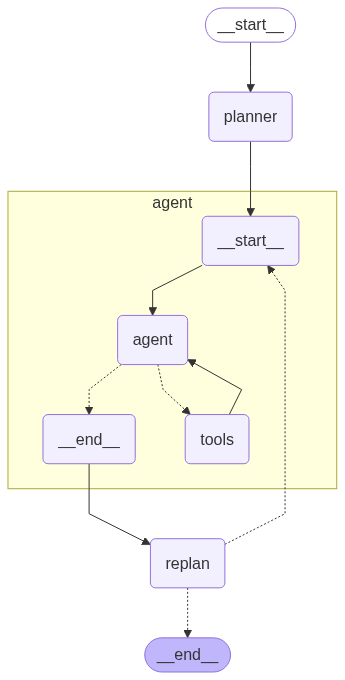

In [12]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

## Inferences

In [13]:
config = {"recursion_limit": 50}
inputs = {
    "input": "Solve for all real solutions x to the equation: sqrt(x -2) = 3"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Step 1: Square both sides of the equation to get rid of the square root.', 'Step 2: Simplify the resulting equation and solve for x', 'Simplify the equation: x-2=9']}


GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT